In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn.decomposition import PCA
import sklearn.utils

plt.rcParams['svg.fonttype'] = 'none'

In [2]:
def get_explained_variance(components, X):
    C = np.cov(X.T)
    return np.diag(components @ C @ components.T) / np.trace(C)


def train_pca(trial_mean_1,
              trial_mean_2,
              resample=False,
              sample_size=1.0,
              random_state=None):
    trial_mean_1 = trial_mean_1 - trial_mean_1.mean(axis=0)
    trial_mean_2 = trial_mean_2 - trial_mean_2.mean(axis=0)

    if resample:
        n_samples = int(sample_size * trial_mean_1.shape[1])
        indices = sklearn.utils.resample(np.arange(trial_mean_1.shape[1]),
                                         n_samples=n_samples,
                                         random_state=random_state)
        trial_mean_1 = trial_mean_1[:, indices]
        trial_mean_2 = trial_mean_2[:, indices]

    pca = PCA(n_components=num_components, random_state=random_state)
    pca.fit(trial_mean_1)
    explained_variance_11 = pca.explained_variance_ratio_
    explained_variance_12 = get_explained_variance(pca.components_,
                                                   trial_mean_2)

    pca.fit(trial_mean_2)
    explained_variance_21 = get_explained_variance(pca.components_,
                                                   trial_mean_1)
    explained_variance_22 = pca.explained_variance_ratio_

    alignment_index_1 = (explained_variance_21.sum() /
                         explained_variance_11.sum())
    alignment_index_2 = (explained_variance_12.sum() /
                         explained_variance_22.sum())

    return {
        'explained_variance_11': explained_variance_11,
        'explained_variance_12': explained_variance_12,
        'explained_variance_21': explained_variance_21,
        'explained_variance_22': explained_variance_22,
        'alignment_index_1': alignment_index_1,
        'alignment_index_2': alignment_index_2
    }

In [3]:
data_dir = Path('..') / 'data'

num_trial = 30
num_intertrial = 0
regress_out = False

num_components = 7
num_draws = 1000
sample_size = 1

In [4]:
suffix = '-regressed-out' if regress_out else ''
data_file = data_dir / f'trial-means{suffix}.npz'
data = np.load(data_file, allow_pickle=True)
trial_means = data['trial_means'].item()
crossday_indices = data['crossday_indices'].item()

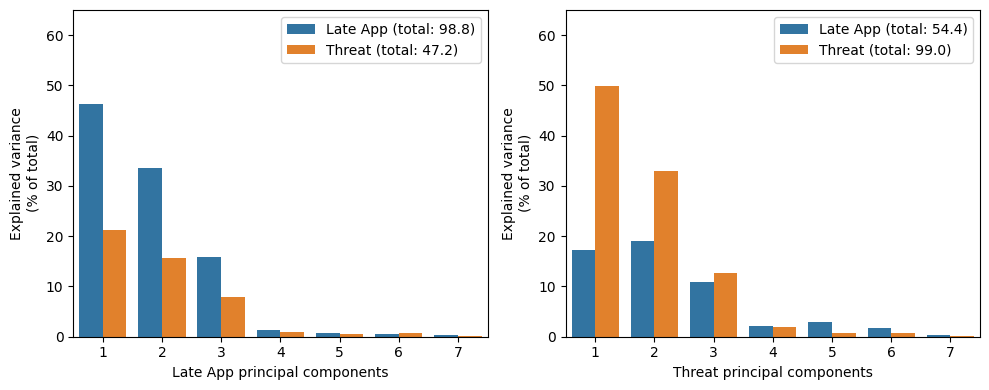

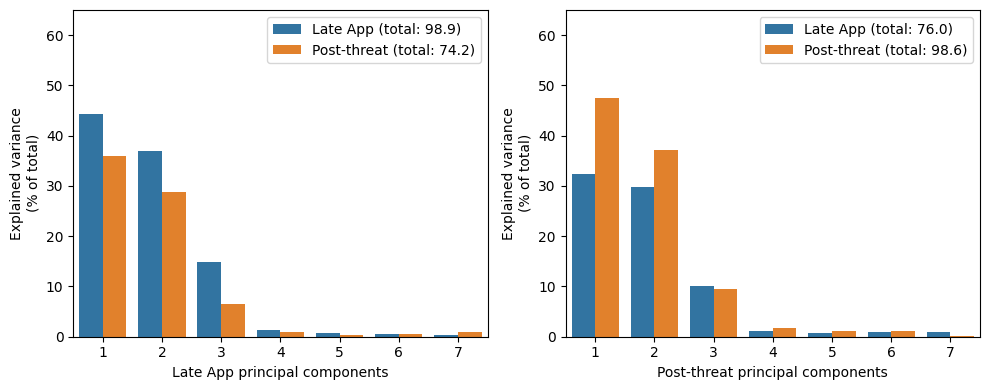

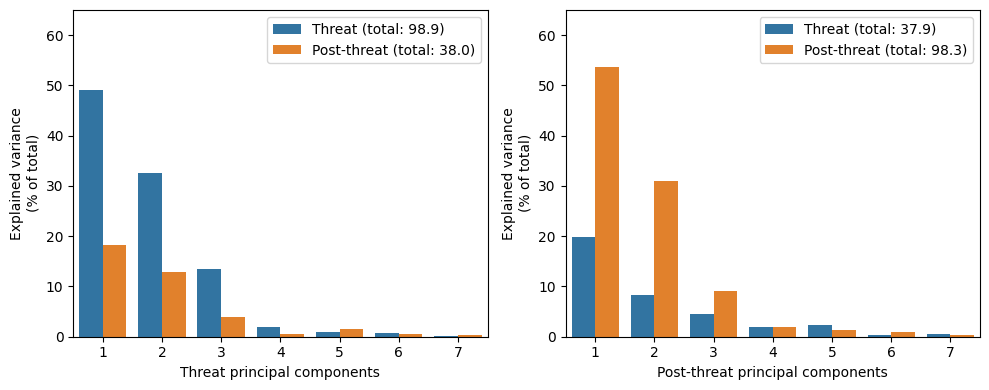

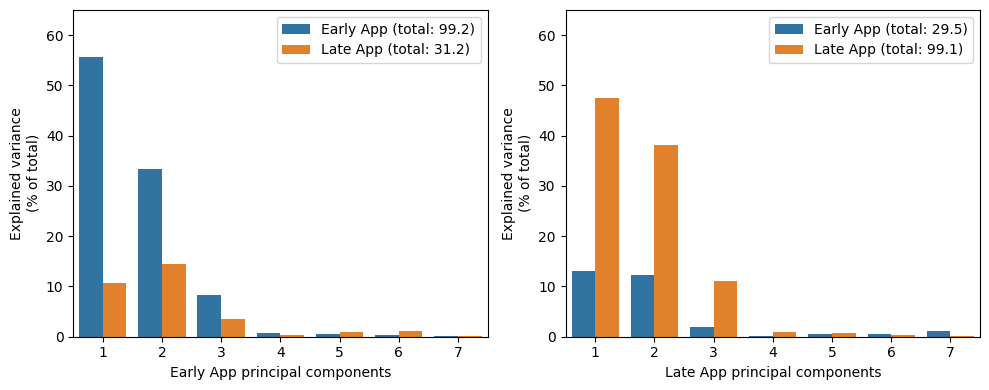

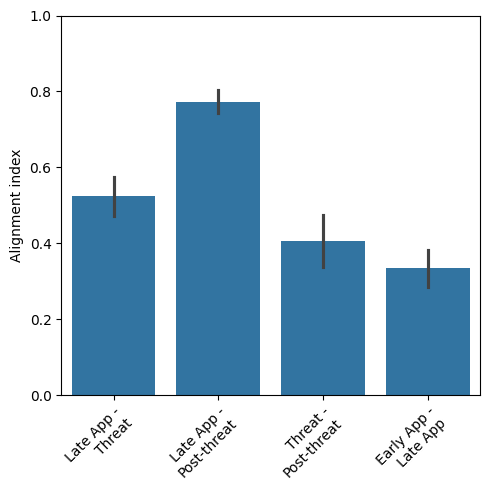

In [5]:
same_day = False
if same_day:
    pairs = [
        ('Late App first half', 'Late App second half'),
        ('Threat first half', 'Threat second half'),
        ('Post-threat first half', 'Post-threat second half'),
    ]
else:
    pairs = [('Late App', 'Threat'), ('Late App', 'Post-threat'),
             ('Threat', 'Post-threat'), ('Early App', 'Late App')]

records = []
for condition_1, condition_2 in pairs:
    trial_means_1 = np.hstack(
        [trial_mean for trial_mean in trial_means[condition_1].values()])
    trial_means_2 = np.hstack(
        [trial_mean for trial_mean in trial_means[condition_2].values()])

    indices = crossday_indices[(condition_1, condition_2)]
    trial_means_1 = trial_means_1[indices[0]].T
    trial_means_2 = trial_means_2[indices[1]].T

    result = train_pca(trial_means_1, trial_means_2)
    locals().update(result)

    label_1 = f'{condition_1} (total: {100 * explained_variance_11.sum():.1f})'
    label_2 = f'{condition_2} (total: {100 * explained_variance_12.sum():.1f})'
    data = {
        'component':
            np.tile(np.arange(num_components) + 1, 2),
        'explained_variance':
            100 * np.hstack([explained_variance_11, explained_variance_12]),
        'condition': [label_1] * num_components + [label_2] * num_components
    }

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    ax = sns.barplot(pd.DataFrame(data),
                     x='component',
                     y='explained_variance',
                     hue='condition')
    plt.xlabel(f'{condition_1} principal components')
    plt.ylabel('Explained variance\n(% of total)')
    plt.ylim([0, 65])
    ax.legend_.set_title(None)

    label_1 = f'{condition_1} (total: {100 * explained_variance_21.sum():.1f})'
    label_2 = f'{condition_2} (total: {100 * explained_variance_22.sum():.1f})'
    data = {
        'principal-component':
            np.tile(np.arange(num_components) + 1, 2),
        'explained-variance':
            100 * np.hstack([explained_variance_21, explained_variance_22]),
        'condition': [label_1] * num_components + [label_2] * num_components
    }

    plt.subplot(1, 2, 2)
    ax = sns.barplot(pd.DataFrame(data),
                     x='principal-component',
                     y='explained-variance',
                     hue='condition')
    plt.xlabel(f'{condition_2} principal components')
    plt.ylabel('Explained variance\n(% of total)')
    plt.ylim([0, 65])
    ax.legend_.set_title(None)

    plt.tight_layout()
    plt.show()
    plt.close()

    records += [{
        'pair': f'{condition_1} - {condition_2}',
        'alignment_index': np.mean([alignment_index_1, alignment_index_2]),
        'boostrapped': False
    }]
    for i in range(num_draws):
        result = train_pca(trial_means_1,
                           trial_means_2,
                           resample=True,
                           sample_size=sample_size,
                           random_state=i)
        alignment_index = np.mean(
            [result['alignment_index_1'], result['alignment_index_2']])
        records += [{
            'pair': f'{condition_1} -\n{condition_2}',
            'alignment_index': alignment_index,
            'boostrapped': True
        }]

df = pd.DataFrame.from_records(records)
df = df[df['boostrapped']]

plt.figure(figsize=(5, 5))
sns.barplot(df, x='pair', y='alignment_index', errorbar='sd')
plt.xlabel('')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.ylabel('Alignment index')
plt.ylim([0, 1])

plt.tight_layout()
plt.show()
plt.close()

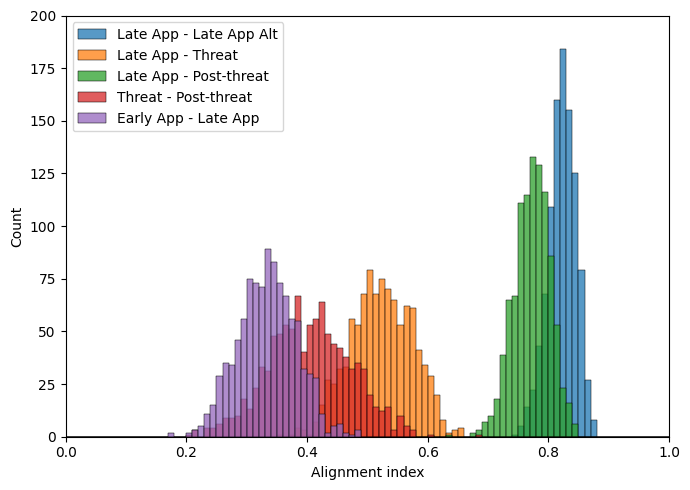

(Late App - Late App Alt) <-> (Late App - Threat) p-value: 0.000e+00
(Late App - Late App Alt) <-> (Late App - Post-threat) p-value: 9.500e-02
(Late App - Late App Alt) <-> (Threat - Post-threat) p-value: 0.000e+00
(Late App - Late App Alt) <-> (Early App - Late App) p-value: 0.000e+00
(Late App - Threat) <-> (Late App - Post-threat) p-value: 0.000e+00
(Late App - Threat) <-> (Threat - Post-threat) p-value: 7.800e-02
(Late App - Threat) <-> (Early App - Late App) p-value: 3.000e-03
(Late App - Post-threat) <-> (Threat - Post-threat) p-value: 0.000e+00
(Late App - Post-threat) <-> (Early App - Late App) p-value: 0.000e+00
(Threat - Post-threat) <-> (Early App - Late App) p-value: 1.960e-01


In [6]:
pairs = [('Late App', 'Late App Alt'), ('Late App', 'Threat'),
         ('Late App', 'Post-threat'), ('Threat', 'Post-threat'),
         ('Early App', 'Late App')]

alignment_indices = {}
for condition_1, condition_2 in pairs:
    trial_means_1 = np.hstack(
        [trial_mean for trial_mean in trial_means[condition_1].values()])
    trial_means_2 = np.hstack(
        [trial_mean for trial_mean in trial_means[condition_2].values()])

    indices = crossday_indices[(condition_1, condition_2)]
    trial_means_1 = trial_means_1[indices[0]].T
    trial_means_2 = trial_means_2[indices[1]].T

    align_indices = []
    for i in range(num_draws):
        result = train_pca(trial_means_1,
                           trial_means_2,
                           resample=True,
                           sample_size=sample_size,
                           random_state=i)
        locals().update(result)
        align_indices += [np.mean([alignment_index_1, alignment_index_2])]

    alignment_indices[(condition_1, condition_2)] = align_indices

plt.figure(figsize=(7, 5))
for condition_1, condition_2 in pairs:
    align_indices = alignment_indices[(condition_1, condition_2)]
    sns.histplot(align_indices,
                 label=f'{condition_1} - {condition_2}',
                 binrange=(0, 1),
                 bins=100)

plt.xlabel('Alignment index')
plt.xlim([0, 1])
plt.ylim([0, 200])
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()
plt.close()

for i, pair_1 in enumerate(pairs):
    for pair_2 in pairs[i + 1:]:
        if pair_1 == pair_2:
            continue
    
        diff = (np.array(alignment_indices[pair_1]) -
                np.array(alignment_indices[pair_2]))
        pvalue = stats.percentileofscore(diff, 0) / 100
        if pvalue > 0.5:
            pvalue = 1 - pvalue

        label = f'({pair_1[0]} - {pair_1[1]}) <-> ({pair_2[0]} - {pair_2[1]})'
        print(f'{label} p-value: {pvalue:.3e}')